# Quickstart: 入札オークション (RTB) のシミュレーション (環境設定)

このノートブックでは入札オークション (Real-Time Bidding; RTB) のシミュレーション環境をカスタマイズする例を紹介します．

特に、以下の4つの順番で解説していきます: 

1. 入札シミュレーションとオンライン強化学習
2. 標準的な環境設定
3. 環境設定のカスタマイズ
4. 入札設定のカスタマイズ

\* このライブラリは，オンラインとオフラインの方策・モデルベース評価で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．

In [ ]:
# SCOPE-RL モジュールのインポート
import scope_rl
from scope_rl.policy import OnlineHead

# import rtbgym modules
from rtbgym import RTBEnv, CustomizedRTBEnv
from rtbgym.utils import NormalDistribution

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state

In [3]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345
random_ = check_random_state(random_state)

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データ生成，オフライン強化学習
まず初めに，今回用いるRTB環境を紹介します．

#### 強化学習でのRTB環境のセットアップ
RTBにおいて強化学習エージェントの目的は，予算制約が与えられもとで，1エピソード内のKPI(クリックやコンバージョン)を最大化することです. KPIを最大にするために，エージェントは入札価格関数パラメータ $\alpha$ を選択します．
入札価格関数パラメータ $\alpha$ を利用することで下の入札価格を決定します．\
$bid_{t，i} = \alpha \cdot r^{\ast}$，
ここで$r^{\ast}$はKPIsの予測または期待値を表します.

この問題を制約付きマルコフ決定過程(CMDP)として定式化します.

- `タイムステップ`: 1エピソード(一日，1週間)に含まれるタイムステップ(24時間， 数日など).
- `状態`: それぞれのタイムステップで，環境からフィードバックが返ってきます.
  - タイムステップ
  - 残予算
  - 一つ前のタイムステップでのインプレッション単位の特徴(予算消費率，1インプレッションあたりのコスト，オークション落札率，報酬)
  - 一つ前のタイムステップでの入札関数パラメータ(強化学習エージェントが選ぶ行動) 
- `行動`: エージェントはKPIを最大化するために入札価格パラメータ$\alpha$を選択します.
- `報酬`: 1タイムステップあたりの得られたトータルのクリックまたはコンバージョンの数.
- `制約`: あらかじめ決められた1エピソードあたりの超えてはいけない予算．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).

In [8]:
# 環境のセットアップ
env = RTBEnv(random_state=random_state)

In [15]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # 方策が取りうる最小の値
            maximum=10,  # 方策が取りうる最大の値
        )
    ).create(device=device),
    name="random",
)
agent.build_with_env(env)

In [16]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [17]:
# 環境からのフィードバック
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


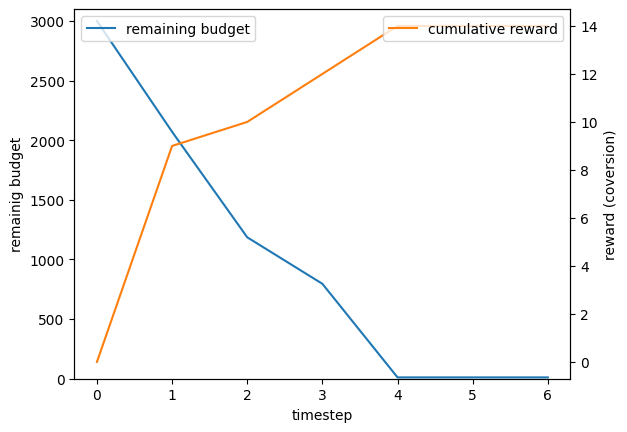

In [18]:
# 累積報酬と残予算の変遷を可視化しています
# 目的は予算制約の中で強化学習を利用して, 累積報酬を最大化する方策を得ることです

def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    remaining_budget = [obs[1]]
    cumulative_reward = [0]

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        remaining_budget.append(obs[1])
        cumulative_reward.append(cumulative_reward[-1] + reward)

    # プロット
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(remaining_budget[:-1], label='remaining budget')
    ax2 = ax1.twinx()
    ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('remainig budget')
    ax1.set_ylim(0, env.initial_budget + 100)
    ax2.set_ylabel('reward (coversion)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 1. 標準的な環境設定

SCOPE-RLでは，離散行動空間と連続行動空間の両方で標準的な環境を設定しています．

これらの環境は報酬予測器として`sklearn.linear_model.LogisticRegression()`を利用しており、以下の行動空間を持ちます．

In [19]:
# 離散行動空間
env = gym.make("RTBEnv-discrete-v0")
print(env.action_meaning)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [20]:
# 連続行動空間
env = gym.make("RTBEnv-continuous-v0")
print(env.action_space)

Box(0.1, 10.0, (1,), float64)


## 2. 環境設定のカスタマイズ
以下では、シミュレーション環境をカスタマイズする方法を解説します．

環境には以下の変数があります．
- `objective`: RTBの重要性能指標 (KPI, "click"または"conversion")
- `cost_indicator`:コストが発生するタイミング("impression", "click", "conversion")
- `step_per_episode`: 一エピソードでの意思決定の数
- `initial_budget`: 一エピソードでの初期予算 (制約)
- `n_ads`: 入札オークション環境上の広告の数
- `n_users`: 入札オークション環境上のユーザーの数
- `ad_feature_dim`: 広告の特徴ベクトルの次元
- `user_feature_dim`: ユーザーの特徴ベクトルの次元
- `ad_feature_vector`: 広告特徴量 (ベクトル)
- `user_feature_vector`: ユーザー特徴量 (ベクトル)
- `ad_sampling_rate`: 入札オークションでどの広告を選ぶかを決めるサンプリング確率
- `user_sampling_rate`: 入札オークションでどのユーザーが対象となるかを決めるサンプリング確率
- `WinningPriceDistribution`: 入札オークションの落札価格分布
- `ClickTroughRate`: クリック率 (クリック/ インプレッション)
- `ConversionRate`: コンバージョン率 (コンバージョン/ クリック)
- `standard_bid_price_distribution`: 平均インプレッション確率が0.5と予想される時の入札価格の分布
- `minimum_standard_bid_price`: 標準入札価格の最低値
- `search_volume_distribution`: タイムステップごとの検索ボリューム分布
- `minimum_search_volume`: タイムステップごとの最小の検索ボリューム
- `random_state`: ランダムシード

#### ケース 1. 一般的な環境パラメタのカスタマイズ

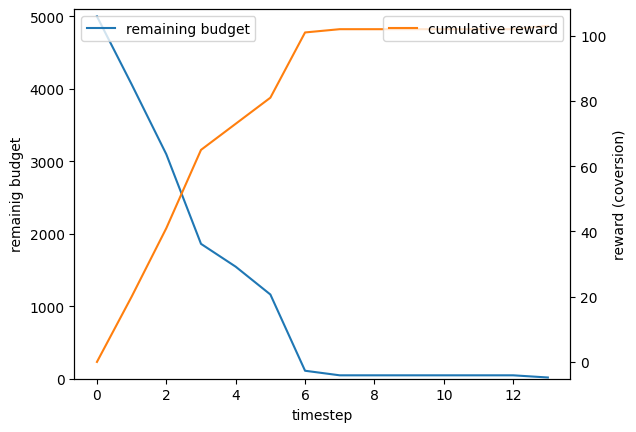

In [21]:
env = RTBEnv(
    objective="click",  # クリック数の合計を最大化
    cost_indicator="click",  # クリックするごとにコストが発生
    step_per_episode=14,  # 1エピソード14日とする14 days as an episode
    initial_budget=5000,  # 14日で予算は5000
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### ケース 2. 広告とユーザのカスタマイズ

In [22]:
# 入札には以下の広告を利用します
ad_features = np.sign(random_.normal(size=(5, 10))).astype(int)
ad_names, feature_names = [f"ad{i+1}" for i in range(5)], [f"feature{i+1}" for i in range(10)]
ad_df = pd.DataFrame(ad_features, columns=feature_names, index=ad_names)
ad_df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
ad1,-1,1,-1,-1,1,1,1,1,1,1
ad2,1,-1,1,1,1,1,-1,-1,1,-1
ad3,-1,1,1,-1,-1,1,1,1,1,1
ad4,-1,-1,-1,-1,-1,1,-1,1,-1,1
ad5,-1,-1,-1,-1,-1,1,1,-1,1,1


In [23]:
# 以下の100人のユーザーがランダムに検索クエリを投げると仮定します
user_features = random_.normal(size=(100, 5))
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,0.069877,0.246674,-0.011862,1.004812,1.327195
user2,-0.919262,-1.549106,0.022185,0.758363,-0.660524
user3,0.862580,-0.010032,0.050009,0.670216,0.852965
user4,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302
user5,-1.332610,1.074623,0.723642,0.690002,1.001543
...,...,...,...,...,...
user96,-1.686933,1.089539,2.060882,-0.241235,-0.947872
user97,0.676294,-0.653356,-0.652295,0.528828,0.357793
user98,0.188649,0.869417,-0.050667,-0.716365,-0.103259
user99,-1.141037,-0.500777,-0.389301,-0.473851,0.128664


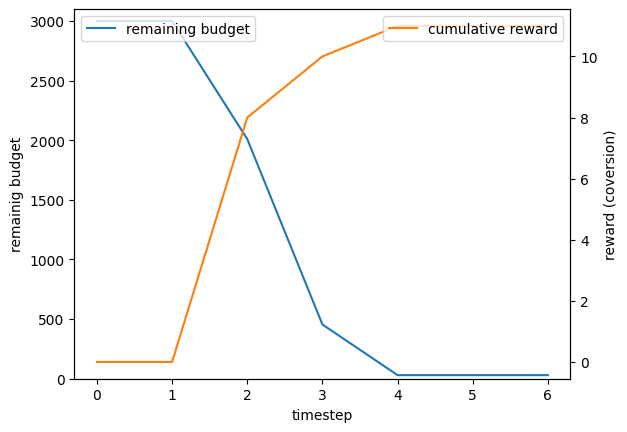

In [24]:
# 上記のデータを使って，以下のようにオークションをシミュレーションできる
# (timestep, n_ads/users)または(n_ads/users, )の配列を与えることでad_sampling_rateとuser_feature_vectorは,
# タイムステップごとに定義することも，タイムステップをまたいで定義することもできる
env = RTBEnv(
    step_per_episode=7,  # 週7日
    n_ads=5,  # 5つの広告を利用
    n_users=100,  # 100人のユーザーが存在
    ad_feature_dim=10,  # それぞれの広告は10次元の特徴を持つ
    user_feature_dim=5,  # それぞれのユーザーは5次元の特徴を持つ
    ad_feature_vector=ad_features,  # 上で定義した広告の特徴を利用
    user_feature_vector=user_features,  # 上で定義したユーザーの特徴を利用
    ad_sampling_rate=np.ones(5) / 5,  # シミュレーションで全ての広告を一様にサンプルリングする
    user_sampling_rate=np.ones((7, 100)) / 100,  #シミュレーションの全てのタイムステップで全てのユーザーは一様にサンプルリングする
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### ケース 3. オークションの落札価格分布，クリック率，コンバージョン率のカスタマイズ


In [25]:
# 入札価格を使ってオークションの落札価格分布を定義しています.
# デフォルトでは, ガンマ分布を使ってオークションの価格分布をシミュレーションしていることに注意してください.
# 詳しくはrtbgym.WinningPriceDistributionを参照してください.

from rtbgym import BaseWinningPriceDistribution

@dataclass
class CustomizedWinningPriceDistribution(BaseWinningPriceDistribution):
    """Initialization."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    standard_bid_price_distribution: NormalDistribution = NormalDistribution(
        mean=50,
        std=5,
        random_state=12345,
    )
    minimum_standard_bid_price: Optional[Union[int, float]] = None
    random_state: Optional[int] = None
    
    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
    
    def sample_outcome(
        self,
        bid_prices: np.ndarray,
        **kwargs,
    ) -> Tuple[np.ndarray]:
        """各オークションのインプレッションとセカンドプライスを確率的に決定する．."""
        #  単純な正規分布からの落札価格のサンプリング
        winning_prices = self.random_.normal(
            loc=self.standard_bid_price,
            scale=self.standard_bid_price / 5,
            size=bid_prices.shape,
        )
        impressions = winning_prices < bid_prices
        return impressions.astype(int), winning_prices.astype(int)
    
    @property
    def standard_bid_price(self):
        return self.standard_bid_price_distribution.mean

In [26]:
# ここでは, クリック率とコンバージョン率もユーザーと広告の両方の特徴ベクトルを使ってカスタマイズしています.
# rtbgym.ClickThroughRate，rtbgym.ConversionRateも合わせて参照してください.
from rtbgym import BaseClickAndConversionRate
from rtbgym.utils import sigmoid

@dataclass
class CustomizedClickThroughRate(BaseClickAndConversionRate):
    """初期化."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    random_state: Optional[int] = None
    
    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.ad_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.ad_feature_dim, 10),
        )
        self.user_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.user_feature_dim, 10),
        )
    
    def calc_prob(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """CTRの計算 (インプレッションあたりのクリック)."""
        ad_latent = ad_feature_vector @ self.ad_coef
        user_latent = user_feature_vector @ self.user_coef
        ctrs = sigmoid((ad_latent * user_latent).mean(axis=1))
        return ctrs
    
    def sample_outcome(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """impression=Trueの場合にクリックが発生するかどうかを確率的に決定します."""
        ctrs = self.calc_prob(
            timestep=timestep,
            ad_ids=ad_ids,
            user_ids=user_ids,
            ad_feature_vector=ad_feature_vector,
            user_feature_vector=user_feature_vector,
        )
        clicks = self.random_.rand(len(ad_ids)) < ctrs
        return clicks.astype(int)

In [27]:
@dataclass
class CustomizedConversionRate(BaseClickAndConversionRate):
    """初期化."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state + 1)
        self.ad_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.ad_feature_dim, 10),
        )
        self.user_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.user_feature_dim, 10),
        )
    
    def calc_prob(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """CVRの計算 (クリックあたりのコンバージョン)."""
        ad_latent = ad_feature_vector @ self.ad_coef
        user_latent = user_feature_vector @ self.user_coef
        cvrs = sigmoid((ad_latent * user_latent).mean(axis=1))
        return cvrs
    
    def sample_outcome(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """click=Trueの場合にクリックが発生するかどうかを確率的に決定します."""
        cvrs = self.calc_prob(
            timestep=timestep,
            ad_ids=ad_ids,
            user_ids=user_ids,
            ad_feature_vector=ad_feature_vector,
            user_feature_vector=user_feature_vector,
        )
        conversions = self.random_.rand(len(ad_ids)) < cvrs
        return conversions.astype(int)

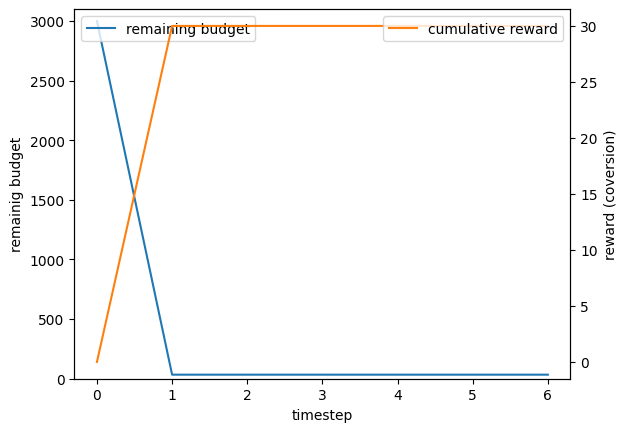

In [28]:
env = RTBEnv(
    WinningPriceDistribution=CustomizedWinningPriceDistribution,
    ClickThroughRate=CustomizedClickThroughRate,
    ConversionRate=CustomizedConversionRate,
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### ケース 4. 標準入札価格と検索ボリューム分布のカスタマイズ

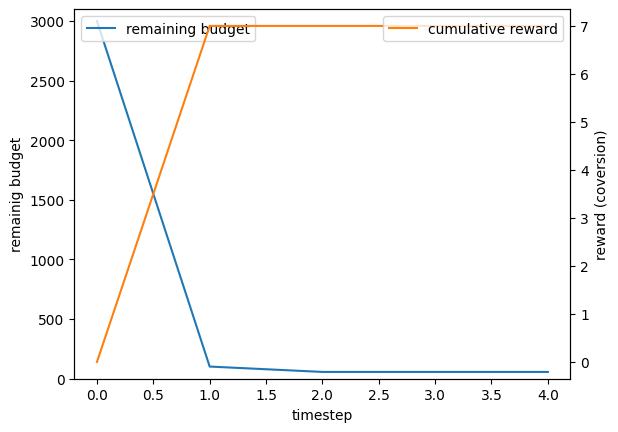

In [ ]:
env = RTBEnv(
    step_per_episode=5,  # 週5日
    standard_bid_price_distribution=NormalDistribution(
        mean=100, 
        std=10, 
        random_state=random_state
    ),
    minimum_standard_bid_price=70,  # 最低標準落札価格は70
    search_volume_distribution=NormalDistribution(
        mean=np.array([100, 200, 100, 200, 300]),  # 検索ボリュームは日によって異なる（タイムステップに依存）
        std=np.ones(5) * 20,
        random_state=random_state,
    ),
    minimum_search_volume=50,  # 毎日少なくとも50のクエリが検索される
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

## 3. 入札設定のカスタマイズ
ここでは，意思決定者が入札設定をカスタマイズする方法を説明します．
具体的には，以下のモジュールを定義することで，独自の行動空間と入札価格計算規則を設定することができます．
- `reward_predictor` 
    入札価格を計算するために，予測報酬を使います．\
        入札価格 = 調整レート * 予測報酬 ( * 定数)\
    None の場合，予測報酬の代わりに真の報酬を使用します．
 

- `scaler` 
    スケーラーは入札価格計算における定数を定義します．\
        入札価格 = 調整レート * 予測報酬 (* 定数)\
        定数 = スケーラー * 標準入札価格\
    ここで標準入札価格は入札価格の平均 (インプレッション確率が約50%の入札価格) を示します．


- `action_space`  
    連続調整率空間 $[0, \infty)$ をエージェント行動空間 $[0.1, 10]$ に変換します．
    離散的なアクションでも連続的なアクションでも構いません．
    (調整率のスケールはスケーラーで調整できます)

    
引数は以下のように与えられる：
- `original_env`: ベースとなるRTB環境
- `reward_predictor`: 入札価格を決定するための報酬を予測する機械学習モデル
- `scaler`: 入札価格決定に使用するスケーリング係数 (定数)
- `action_min`: 調整率の最小値
- `action_max`: 調整率の最大値
- `action_type`: 強化学習エージェントの行動タイプ ("discrete" または "continuous")
- `n_actions`: 離散行動の数
- `action_meaning`: エージェントの行動インデックスと実際の"離散"行動のマッピング関数

In [30]:
# 環境の初期化
env = RTBEnv(random_state=random_state)

#### ケース 1. 連続行動空間を定義

In [31]:
# let's customize the continuous action space
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="continuous",
)

In [32]:
print(custom_env.action_space)

Box(0.1, 10.0, (1,), float64)


In [33]:
# another example
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_min=0.1,
    action_max=0.5,
    action_type="continuous",
)

In [34]:
print(custom_env.action_space)

Box(0.1, 0.5, (1,), float64)


#### ケース 2. 離散行動空間を定義

In [35]:
# let's customize the environment and discretize the action space
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="discrete",
)

In [36]:
print(custom_env.action_space)
print(custom_env.action_meaning)

Discrete(10)
[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [37]:
# another example
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="discrete",
    n_actions=5,
    action_meaning=np.arange(1, 6)
)

In [38]:
print(custom_env.action_space)
print(custom_env.action_meaning)

Discrete(5)
[1 2 3 4 5]


#### ケース 3. 報酬予測器をカスタマイズ

In [39]:
custom_env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),  # 報酬予測器としてロジスティック回帰を利用
    action_type="discrete",
)

In [40]:
custom_env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=None,  # 真の報酬予測器として真の(期待)報酬を利用
    action_type="discrete",
)

データ生成や可視化は以下を参照してください．  [examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb). 

オフライン強化学習やオフ方策評価 (OPE) に関しては以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb) (離散行動空間)， [examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb) (連続行動空間).

OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください. [examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb) (離散行動空間)， [examples/quickstart_ja/rtb/rtb_synthetic_continuous_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_advanced_ja.ipynb) (連続行動空間).

## 参考文献

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.